In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
energy = pd.read_csv('energy_processed.csv')

In [2]:
X_train, X_test, y_train, y_test = train_test_split(energy.drop(columns=['gdp_per_capita', 'country', 'year']),
                                                    energy.gdp_per_capita, test_size=0.3,
                                                    random_state=47)

Let's start with a basic linear regression model.

In [3]:
pipe = make_pipeline(SelectKBest(score_func=f_regression), StandardScaler(), LinearRegression())

In [4]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7824dd5fa9e0>)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [5]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [6]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [7]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [8]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7824dd5fa9e0>)),
                                       ('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24]})

In [9]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [10]:
lr_grid_cv.best_params_

{'selectkbest__k': 24}

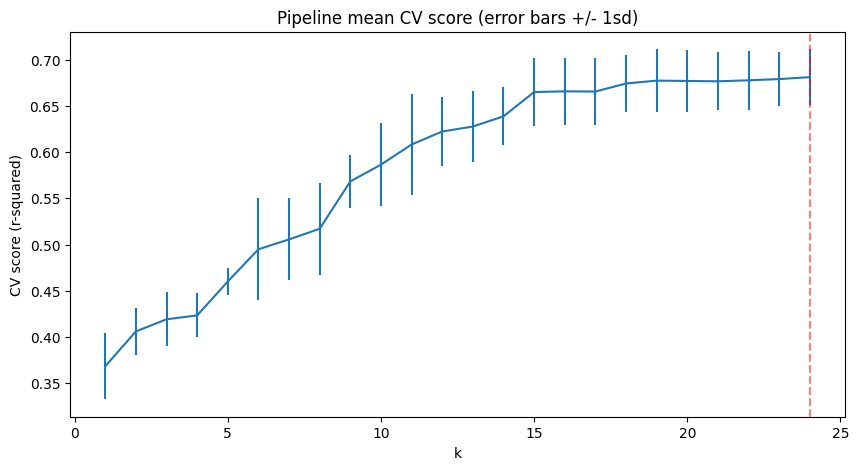

In [11]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [12]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [13]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()]
pd.Series(coefs, index=features).sort_values(ascending=False)

,0
land_area_with_electricity_access,0.973691
electricity_fossil_fuels_output,0.777152
energy_consumption_per_capita,0.471570
renewable_energy_share_primary,0.348437
electricity_fossil_fuels_consumption_ratio,0.310733
clean_fuels_access_%,0.292454
density_category,0.247738
lat,0.202296
quadrant,0.158064
electricity_nuclear_output,0.109865


Strongest coefs: <br>
land_area_with_electricity_access and electricity_fossil_fuels_output	(+) <br>
land_area_with_clean_fuels_access and co2_emissions_per_capita (-)

In [14]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train,
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [15]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(0.37930800225298766, 0.029643292891925067)

In [16]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

0.4018293795950524

Now let's try a random forest pipeline.

In [17]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)
rf_cv_scores = rf_default_cv_results['test_score']

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
    'randomforestregressor__n_estimators': n_est,
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median']
}

rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [18]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 183,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

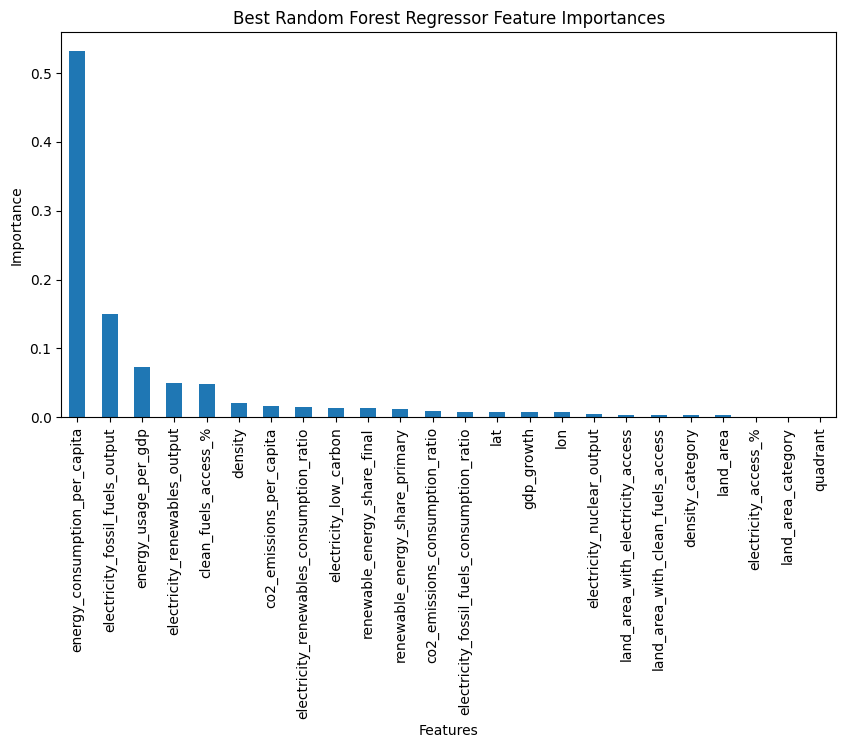

In [19]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns)
rf_feat_imps = rf_feat_imps.sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Best Random Forest Regressor Feature Importances')
plt.show()

Within RF, we see energy_consumption_per_capita as the strongest, and electricity_fossil_fuels_output shows up again as well.

In [20]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

0.4018293795950524

In [21]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

0.13633780962522188

Random forest shows significantly lower MAE (more than 3x lower) than using LR.

Extended steps: <br>

* expand hyperparameter tuning, baysian optimization <br>
* recursive feature elimination <br>
* ensemble methods, bagging, boosting <br>
